# Подготовка данных и окружения

Данные должны быть распакованы и находиться в текущей рабочей директории в следующем формате:
```
./
├── train/
│   ├── images/
│   │   ├── img_0.4150824352465.png
│   │   └── ...
│   └── masks/
│       ├── img_0.4150824352465.png
│       └── ...
└── test/
    ├── img_0.21798600425031.png
    └── ...
```
Также в текущей рабочей директории должны находиться все файлы из репозитория на Github, в особенности requirements.txt и директория с вспомогательными модулями/классами/функциями src
```
./
├── src/
│   ├── data.py
│   ├── inference.py
│   ├── train.py
│   ├── visualizations.py
│   └── utils.py
└── requirements.txt
```

Установим требуемые версии пакетов

In [8]:
!pip install -r ./requirements.txt -qqq

     |████████████████████████████████| 88 kB 4.7 MB/s 
     |████████████████████████████████| 376 kB 16.6 MB/s 
     |████████████████████████████████| 113 kB 28.8 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
     |████████████████████████████████| 48.3 MB 71 kB/s 


Импортируем необходимые пакеты

In [9]:
import sys
import gc
import random
from pathlib import Path
from collections import Counter
import numpy as np
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import cv2
import albumentations as A
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import dill

Зададим стиль для matplotlib

In [10]:
plt.style.use('ggplot')

Загрузим наши модули

In [11]:
from src.utils import RunningAverage, iou_coef
from src.data import SegmentationDataset, get_loaders, get_transforms
from src.train import train
from src.inference import get_batch_predictions, upscale_mask, convert_bool_mask_to_submission
from src.visualizations import visualize_augmentations

Ограничим количество источников недетерминированного поведения



In [12]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

Сохраним расположение текущей рабочей директории

In [13]:
CWD = f'/content/'

Будем производить обучение и предсказание на GPU

In [14]:
device = torch.device('cuda')

# Загрузка данных, визуализации

Создадим списки всех обучающих данных, их масок, тестовых данных

In [15]:
ROOT = Path(CWD)

train_image_path = ROOT / "train" / 'images'
train_mask_path = ROOT / "train" / 'mask'
test_image_path = ROOT / "test"

ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
ALL_TEST_IMAGES = sorted(test_image_path.glob("*.png"))

Посмотрим на распределение разрешений изображений в тренировочном наборе данных

In [16]:
train_shapes = Counter()

for path in ALL_MASKS:
    image = Image.open(str(path))
    train_shapes[image.size] += 1

train_shapes

Counter({(1920, 1080): 2604, (2688, 1512): 5582, (3840, 2160): 17})

Посмотрим на распределение разрешений изображений в тестовом наборе данных

In [17]:
test_shapes = Counter()

for path in ALL_TEST_IMAGES:
    image = Image.open(str(path))
    test_shapes[image.size] += 1

test_shapes

Counter({(2688, 1512): 474, (3840, 2160): 526})

Посмотрим соотношение сторон на изображениях

In [18]:
shapes = np.array(list(train_shapes.keys()))
np.unique(shapes.T[0] / shapes.T[1])

array([1.77777778])

Посмотрим на среднестатистическую маску изображений в обучающем датасете

In [19]:
avg_mask_path = Path(f'{CWD}images/avg_mask.png')

if avg_mask_path.is_file():
    avg_mask = cv2.imread(str(avg_mask_path))
else:
    avg_mask = np.zeros((1512, 2688, 3))

    for path in tqdm(ALL_MASKS):
        mask = cv2.imread(str(path))
        mask[:, :, 0] = mask[:, :, 0] == 6
        mask[:, :, 1] = mask[:, :, 1] == 7    
        mask[:, :, 2] = mask[:, :, 2] == 10
        mask = mask.astype('float32')
        mask = cv2.resize(mask, (2688, 1512), cv2.INTER_NEAREST_EXACT)
        avg_mask += mask

    avg_mask /= len(ALL_MASKS)

    Path(f'{CWD}images').mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(avg_mask_path), avg_mask * 255.)

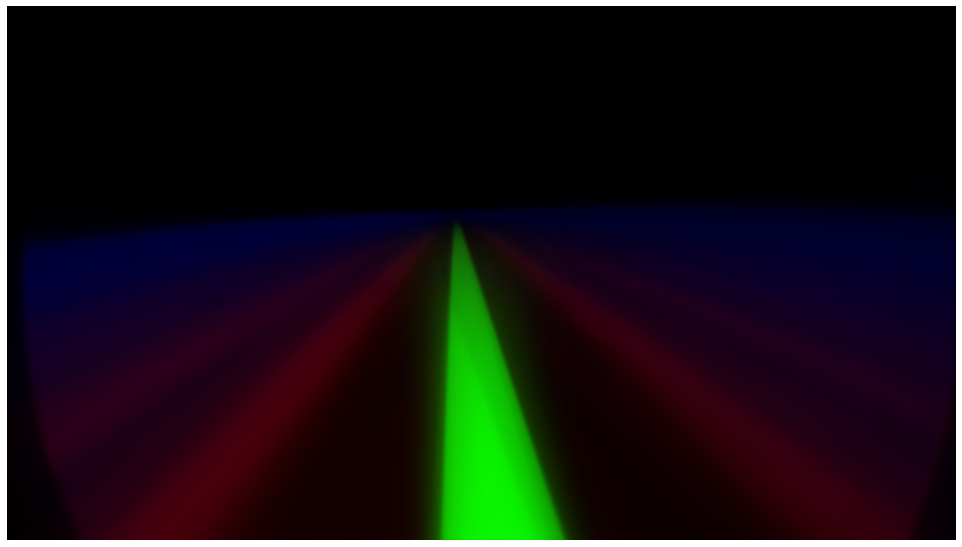

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(avg_mask);

На этой картинке мы видим вероятности появления объектов в какой-либо части изображения и можем увидеть некоторые закономерности. Посмотрим также, есть ли области на которых объекты вообще никогда не появляются

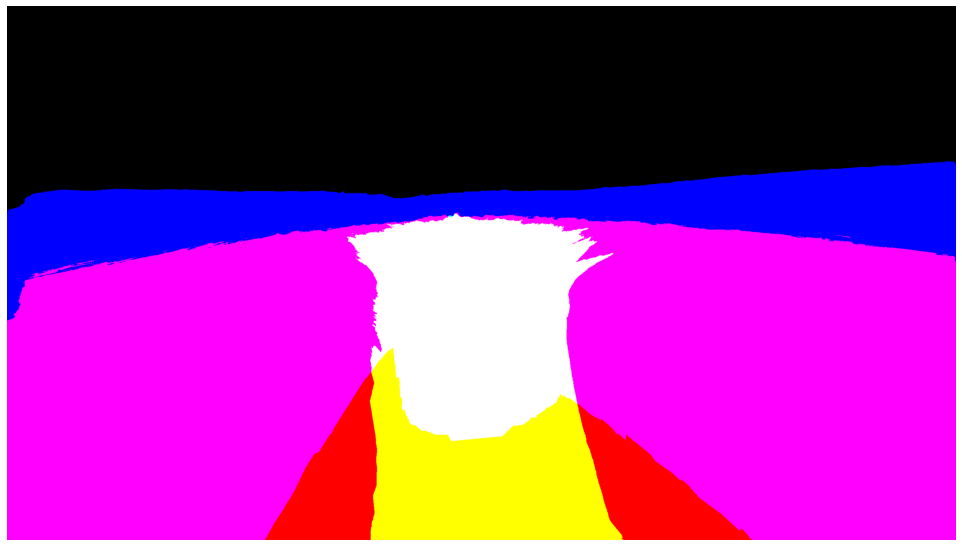

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow((avg_mask != 0).astype('float32'));

Посмотрим на некоторые изображения из датасета и соответствующие им маски

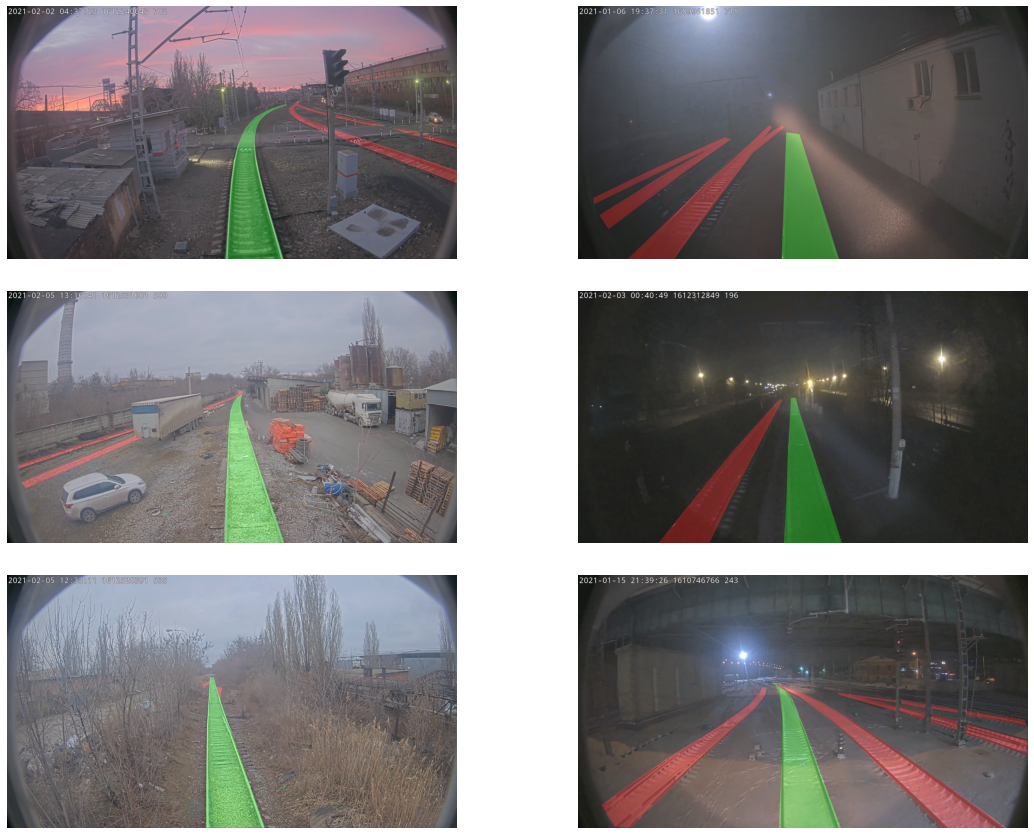

In [22]:
ids = np.random.choice(len(ALL_IMAGES) - 1, 6, replace=False)

images = []

for id in ids:
    image = cv2.imread(str(ALL_IMAGES[id]))
    image = image.astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image /= 255.

    mask = cv2.imread(str(ALL_MASKS[id]))
    mask[:, :, 0] = mask[:, :, 0] == 6
    mask[:, :, 1] = mask[:, :, 1] == 7
    mask[:, :, 2] = mask[:, :, 2] == 10
    mask = mask.astype('float32')

    blend = np.clip(image + mask * .3, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()

In [23]:
del ids, images, fig, ax, train_shapes, test_shapes, shapes, image
del avg_mask, avg_mask_path
gc.collect()

2106

# Аугментации

Будем использовать при обучении различные аугментации - посмотрим как они выглядят

**CoarseDropout** -  вырезание прямоугольных областей в изображении

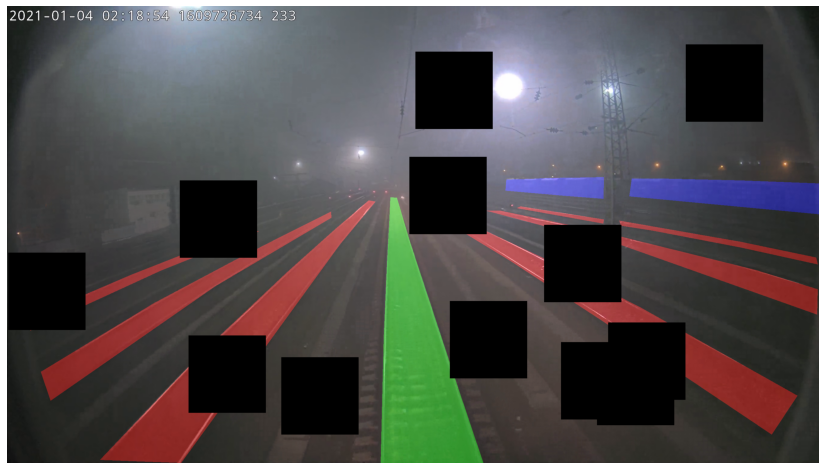

In [24]:
image_path = str(ALL_IMAGES[100])
mask_path = str(ALL_MASKS[100])

transforms = A.Compose([A.CoarseDropout(max_holes=12,
                                        max_height=256,
                                        max_width=256,
                                        min_holes=12,
                                        min_height=256,
                                        min_width=256,
                                        fill_value=0,
                                        mask_fill_value=0,
                                        p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**Perspective** - случайное преобразование входных данных в четырехточечной перспективе

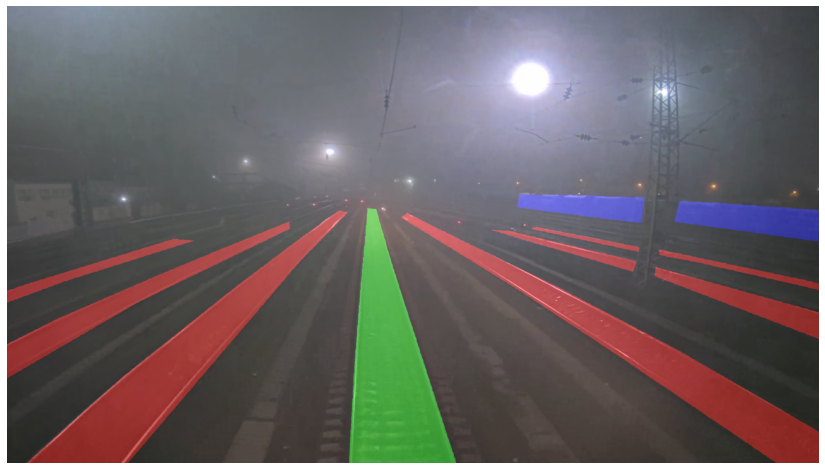

In [25]:
transforms = A.Compose([A.Perspective(scale=(0.1, 0.1), p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**HorizontalFlip** - отражение входных данных по горизонтали вокруг оси y

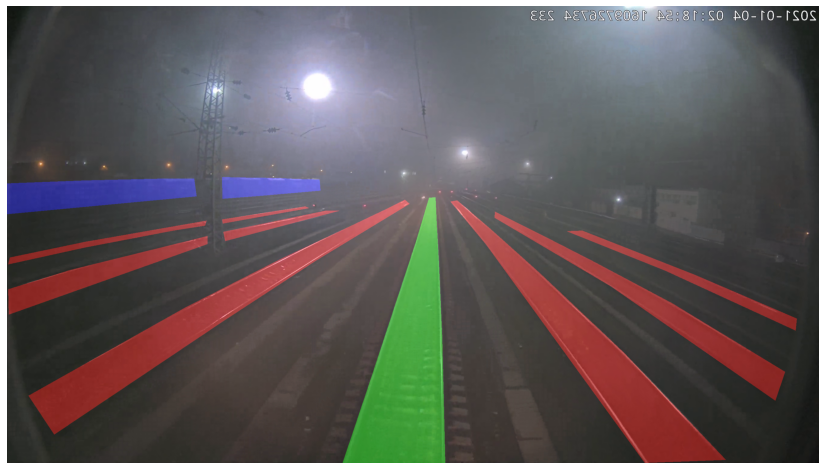

In [26]:
transforms = A.Compose([A.HorizontalFlip(p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**RandomBrightnessContrast** - случайное изменение яркости и контрастности

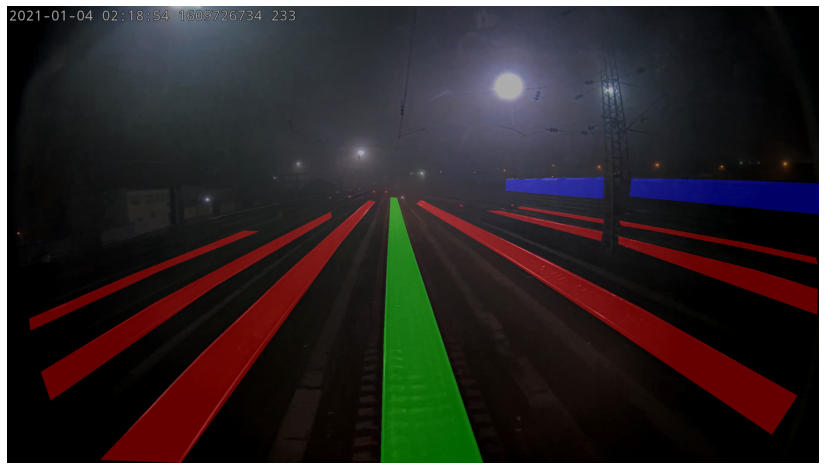

In [27]:
transforms = A.Compose([A.RandomBrightnessContrast(brightness_limit=(-0.25),
                                                   contrast_limit=(0.25),
                                                   p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

**MultiplicativeNoise** - умножение изображения на случайное число или массив чисел

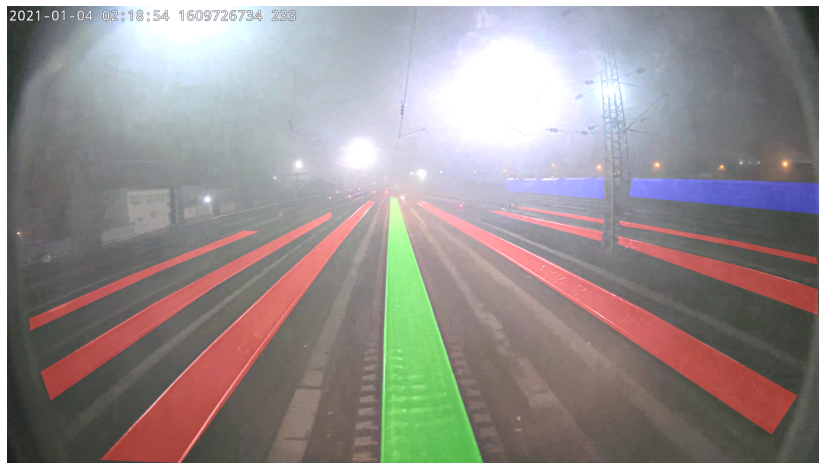

In [28]:
transforms = A.Compose([A.MultiplicativeNoise(multiplier=(1.75, 1.75),
                                              per_channel=True,
                                              p=1)])

image = visualize_augmentations(image_path, mask_path, transforms)

fig, ax = plt.subplots(figsize=(12, 8))
fig.tight_layout()
ax.set_axis_off()
plt.imshow(image);

Для каждой аугментации используется определенная вероятность ее применения - посмотрим как они будут выглядеть в комбинации на наших данных

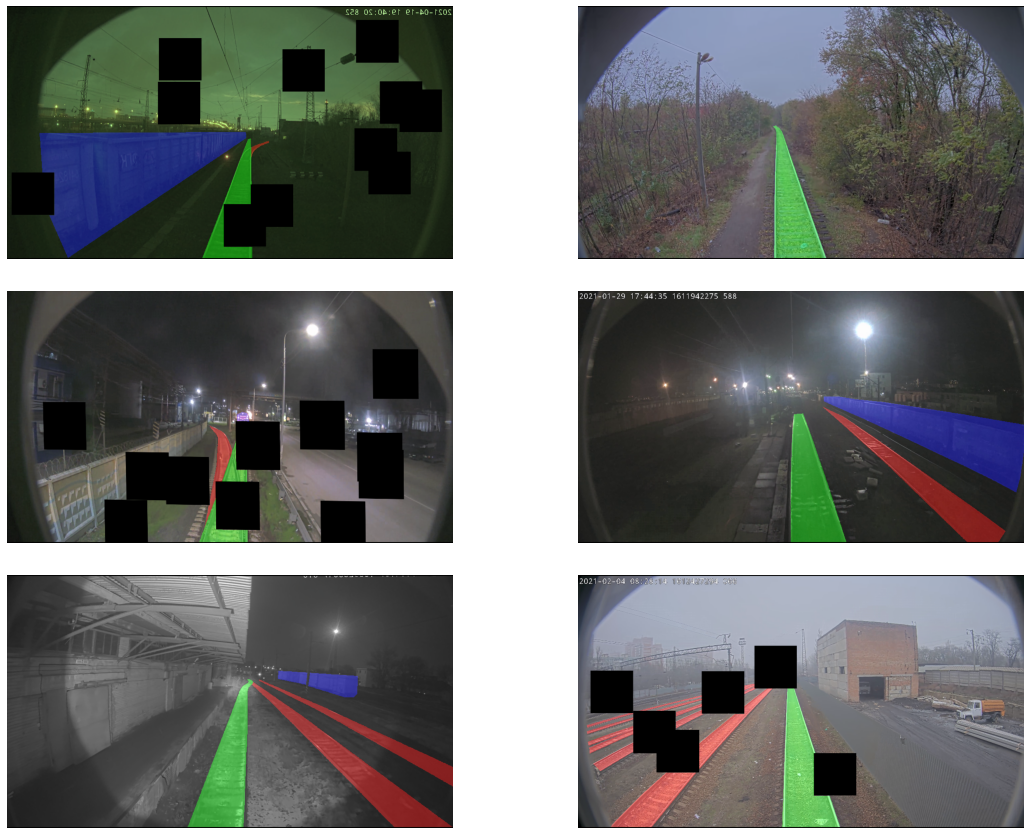

In [29]:
vis_dataset = SegmentationDataset(images = ALL_IMAGES[:6],
                                  masks = ALL_MASKS[:6],
                                  transforms = get_transforms(add_augmentations = True))
vis_loader = DataLoader(vis_dataset, batch_size=1)

images = []
for batch in iter(vis_loader):
    image = batch['image'][0]
    mask = batch['mask'][0]

    image = image.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    image = image * torch.tensor([0.229, 0.224, 0.225])
    image = image + torch.tensor([0.485, 0.456, 0.406])

    blend = np.clip(image + mask * 0.4, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()

# Обучение

Создадим определенные ранее агументации

In [30]:
transforms_train = get_transforms(image_width = 960, image_height = 544, add_augmentations = True)
transforms_test = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Создадим загрузчики для обучающей и валидационной выборки. Будем обучать все модели на одинаковом наборе данных чтобы иметь возможность валидации ансамбля. Будем использовать 95% данных для обучения и 5% для валидации

In [31]:
loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state = SEED,
    train_transforms_fn=transforms_train,
    valid_transforms_fn=transforms_test,
    batch_size=8,
    num_workers = 2,
    k_folds = 20,
    current_fold = 0
)

Начнем обучение наших моделей. Для обучения каждой модели будем применять аккумуляцию градиента и обрезание градиента по норме.

## Pyramid Attention Network, EfficientNet
Обучим модель, состоящую из декодера Pyramid Attention Network и энкодера EfficientNet B4, предобученного на Imagenet с применением Noisy Student

In [32]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/efficientnetb4.pth.tar'
history_path = f'{CWD}weights/history_efficientnetb4'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Веса найдены - пропускаем обучение')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Начинаем обучение')
    model = smp.PAN(encoder_name="tu-tf_efficientnet_b4_ns", encoder_weights='noisy-student', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 25, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Веса найдены - пропускаем обучение


Посмотрим как проходило обучения на графиках

In [33]:
x = list(range(1, 26))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

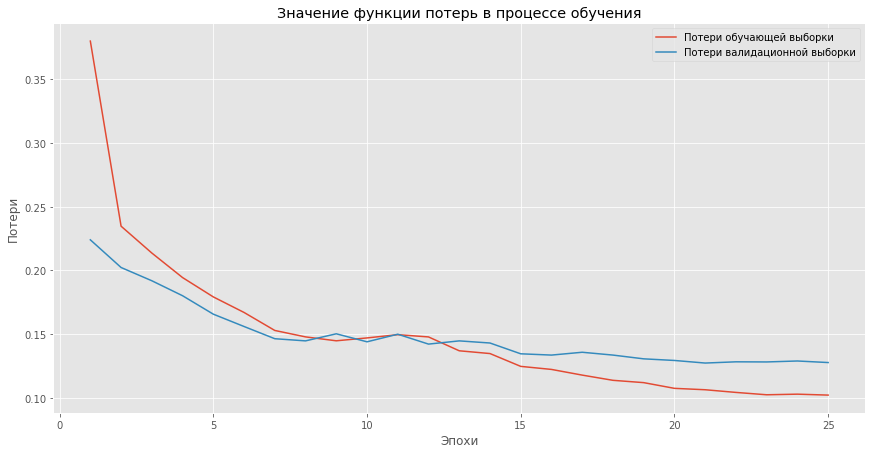

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Потери обучающей выборки')
ax.plot(x, val_loss, label = f'Потери валидационной выборки')
ax.set_title(f'Значение функции потерь в процессе обучения')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Потери')
ax.legend();

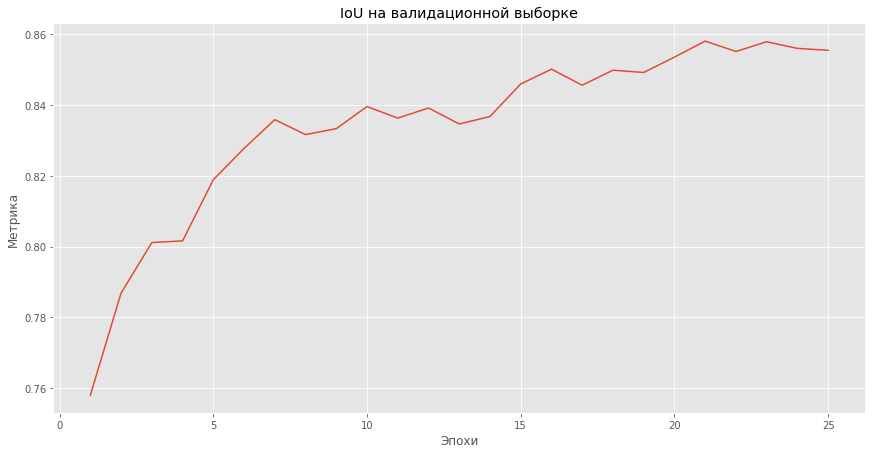

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'IoU на валидационной выборке')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Метрика');

## Pyramid Attention Network, Nfnet
Обучим модель, состоящую из декодера Pyramid Attention Network и модифицированного энкодера NFNet (Normalization Free Net), использующего ECA (Efficient Channel Attention) и функцию активации SiLU. Энкодер предобучен на Imagenet

In [36]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/eca_nfnet_l2.pth.tar'
history_path = f'{CWD}weights/history_eca_nfnet_l2'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Веса найдены - пропускаем обучение')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Начинаем обучение')
    model = smp.PAN(encoder_name="tu-eca_nfnet_l2", encoder_weights='imagenet', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 25, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Веса найдены - пропускаем обучение


In [37]:
x = list(range(1, 26))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

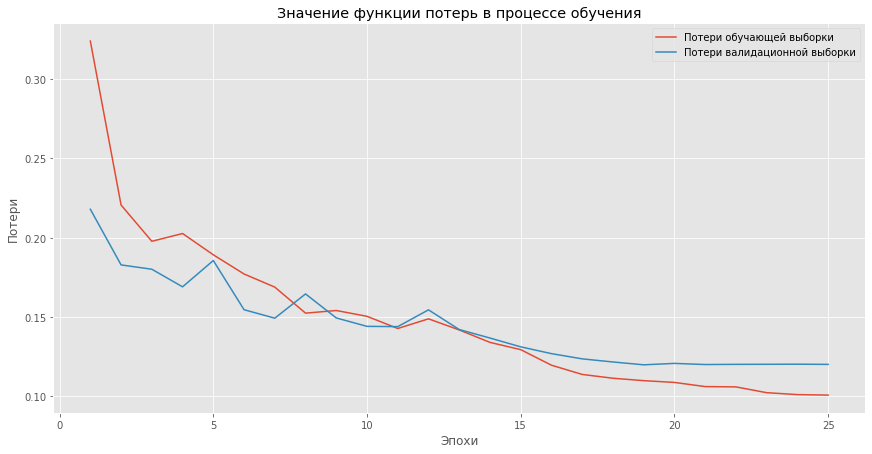

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Потери обучающей выборки')
ax.plot(x, val_loss, label = f'Потери валидационной выборки')
ax.set_title(f'Значение функции потерь в процессе обучения')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Потери')
ax.legend();

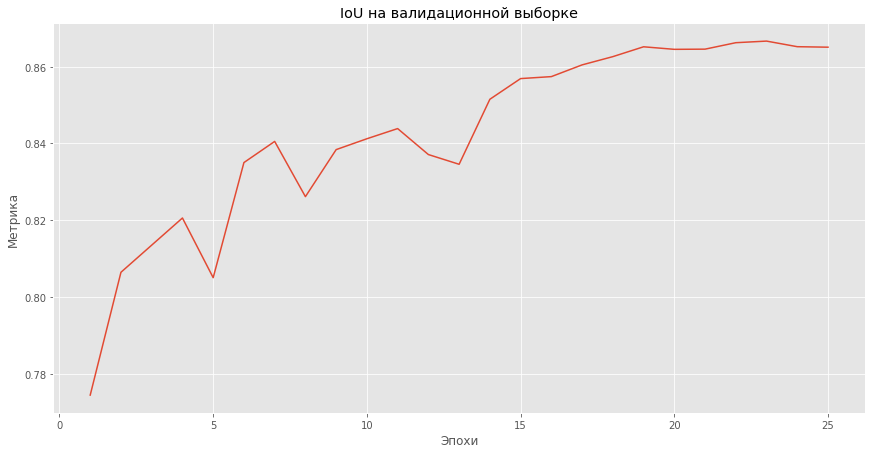

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'IoU на валидационной выборке')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Метрика');

## Pyramid Attention Network, SE-ResNet
Обучим модель, состоящую из декодера Pyramid Attention Network и энкодера SE-ResNet предобученого на Imagenet. SE-ResNet это вариант ResNet, в котором используются блоки squeeze-and-excitation, позволяющие сети выполнять динамическую перекалибровку признаков по каналам


In [40]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/seresnet152d.pth.tar'
history_path = f'{CWD}weights/history_seresnet152d'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Веса найдены - пропускаем обучение')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Начинаем обучение')
    model = smp.PAN(encoder_name="tu-seresnet152d", encoder_weights='imagenet', in_channels=3, classes=3)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, loaders['train'], loaders['val'], 30, lr_scheduler, weights_path, accumulate_every_n_epochs=2, clip_gradient = True)
    with open(history_path, 'wb') as handle:
        dill.dump(history_path, handle, protocol=dill.HIGHEST_PROTOCOL)

Веса найдены - пропускаем обучение


In [41]:
x = list(range(1, 31))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_jac = [e.val_jac for e in history]

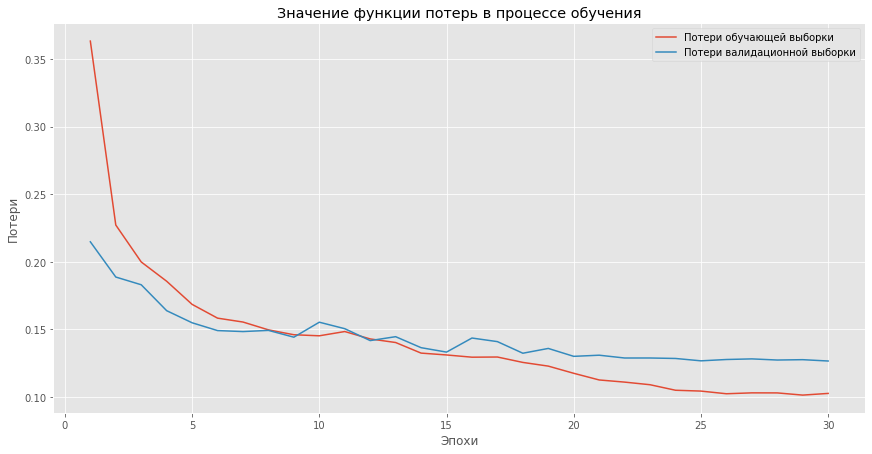

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Потери обучающей выборки')
ax.plot(x, val_loss, label = f'Потери валидационной выборки')
ax.set_title(f'Значение функции потерь в процессе обучения')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Потери')
ax.legend();

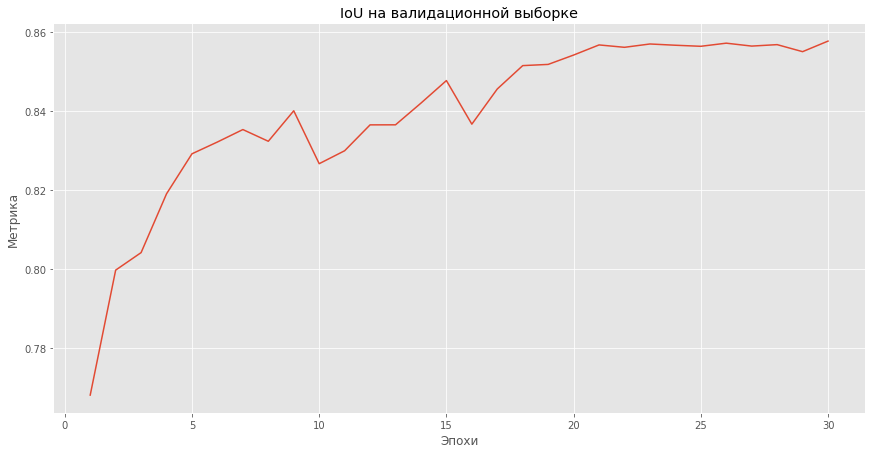

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_jac, label = f'IoU')
ax.set_title(f'IoU на валидационной выборке')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Метрика');

# Ансамбль моделей

Построим комбинацию моделей, которая, позволить получить более эффективные и точные предсказания


```
+----------------------+
| PAN, EfficientNet B4 +------+
+----------------------+      |
                              |     +--------------------+
+----------------------+      |     |     Ансамбль:      |      +--------------+
| PAN, ECA NFNet L2    +----------->+ Взвешенное среднее +----->+ Предсказание |
+----------------------+      |     | для каждого объекта|      +--------------+
                              |     +--------------------+
+----------------------+      |
| PAN, SE-ResNet 152d  +------+
+----------------------+

```



Загрузим наши модели

In [44]:
models_efficientnet = [torch.load(f'{CWD}weights/efficientnetb4.pth.tar')]
models_nfnet = [torch.load(f'{CWD}weights/eca_nfnet_l2.pth.tar')]
models_resnet = [torch.load(f'{CWD}weights/seresnet152d.pth.tar')]

Будем производить тестирование комбинаций моделей на отложенных данных которые модели не видели

In [45]:
indices = np.arange(len(ALL_IMAGES))
skf = KFold(20, shuffle=True, random_state=0)
splits = list(skf.split(indices))
id_train, id_val = splits[0]
val_data = SegmentationDataset(images = np.array(ALL_IMAGES)[id_val], masks = np.array(ALL_MASKS)[id_val], transforms = None)

In [46]:
transforms_960x544 = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Создадим словари с предсказаниями моделей и настоящими масками

In [47]:
predictions_efficientnet = {}
predictions_nfnet = {}
predictions_resnet = {}
masks_true = {}

for batch_data in tqdm(val_data):
    image = batch_data['image']
    mask = batch_data['mask']
    filename = batch_data['filename']

    transformed_img_mask_960x544 = transforms_960x544(image=image, mask = mask)
    image_960x544 = transformed_img_mask_960x544['image'].unsqueeze(0)
    mask_true_960x544 = transformed_img_mask_960x544['mask'].permute(2, 0, 1).unsqueeze(0).to(device)

    predictions_efficientnet[filename] = get_batch_predictions(models_efficientnet, image_960x544, device)
    predictions_nfnet[filename] = get_batch_predictions(models_nfnet, image_960x544, device)
    predictions_resnet[filename] = get_batch_predictions(models_resnet, image_960x544, device)
    masks_true[filename] = mask_true_960x544

100%|██████████| 411/411 [02:35<00:00,  2.65it/s]


Подберем коэффициенты для лучшей комбинации наших моделей. Так как у нас несколько объектов, модели могут показывать разную точность и эффективность для каждого, поэтому будем подбирать коэффициенты для каждого объекта по отдельности

In [48]:
for channel in range(3):
    best_val_jac = 0.0
    best_alpha = 0.0
    best_beta = 0.0
    best_gamma = 0.0

    with tqdm(total = 99 ** 2, leave=False, file=sys.stdout) as t:
        for alpha in np.arange(0.01, 1.00, 0.01):
            for beta in np.arange(0.01, 1.00, 0.01):
                val_jac_avg = RunningAverage()

                for key, y_true in masks_true.items():
                    y_pred = alpha * predictions_efficientnet[key] \
                            + beta * predictions_nfnet[key] \
                            + (1 - alpha - beta) * predictions_resnet[key]
                    jac = iou_coef(y_true[:, channel, :, :].unsqueeze(0), y_pred[:, channel, :, :].unsqueeze(0))
                    val_jac_avg.update(jac.item())
                
                if val_jac_avg() > best_val_jac:
                    best_alpha = alpha
                    best_beta = beta
                    best_gamma = 1 - alpha - beta
                    best_val_jac = val_jac_avg()
                
                t.update()

    print(f'Лучшие коэффициенты для объекта {channel}: '
          f'alpha {best_alpha:.2f}, beta {best_beta:.2f}, gamma {best_gamma:.2f} '
          f'с метрикой IoU для объекта: {best_val_jac:.4f}')

Лучшие коэффициенты для объекта 0: alpha 0.41, beta 0.50, gamma 0.09 с метрикой IoU для объекта: 0.7898
Лучшие коэффициенты для объекта 1: alpha 0.15, beta 0.44, gamma 0.41 с метрикой IoU для объекта: 0.9375
Лучшие коэффициенты для объекта 2: alpha 0.11, beta 0.50, gamma 0.39 с метрикой IoU для объекта: 0.8891


In [49]:
del predictions_efficientnet, predictions_nfnet, predictions_resnet, masks_true
gc.collect()
torch.cuda.empty_cache()

# Предсказание

Мы определились с финальной архитектурой - предскажем тестовые данные соревнования

In [50]:
test_data = SegmentationDataset(images = ALL_TEST_IMAGES, masks = None, transforms = None)

In [55]:
!mkdir -p {CWD}submission/

Загрузим веса обученных моделей

In [56]:
models_efficientnet = [torch.load(f'{CWD}weights/efficientnetb4.pth.tar')]
models_nfnet = [torch.load(f'{CWD}weights/eca_nfnet_l2.pth.tar')]
models_resnet = [torch.load(f'{CWD}weights/seresnet152d.pth.tar')]

In [57]:
transforms_960x544 = get_transforms(image_width = 960, image_height = 544, add_augmentations = False)

Предскажем и сохраним результаты на диск

In [58]:
for batch_data in tqdm(test_data):
    image = batch_data['image']
    filename = batch_data['filename']
    original_width, original_height = batch_data['original_width'], batch_data['original_height']

    image_960x544 = transforms_960x544(image=image)['image'].unsqueeze(0)
    output_efficientnet = get_batch_predictions(models_efficientnet, image_960x544, device)
    output_nfnet = get_batch_predictions(models_nfnet, image_960x544, device)
    output_resnet = get_batch_predictions(models_resnet, image_960x544, device)
    
    coeff_efficientnet = torch.tensor([[[[0.41]],[[0.15]],[[0.11]]]]).to(device)
    coeff_nfnet = torch.tensor([[[[0.50]],[[0.44]],[[0.5]]]]).to(device)
    coeff_resnet = torch.tensor([[[[0.09]],[[0.41]],[[0.39]]]]).to(device)

    mask_pred = coeff_efficientnet * output_efficientnet \
                + coeff_nfnet * output_nfnet \
                + coeff_resnet * output_resnet

    mask_pred = mask_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()
    mask_pred = upscale_mask(mask_pred, original_height, original_width)
    mask = convert_bool_mask_to_submission(mask_pred, threshold=0.5)
    cv2.imwrite(f'{CWD}submission/{filename}', mask)

100%|██████████| 1000/1000 [10:50<00:00,  1.54it/s]


Создадим архив с предсказаниями

In [59]:
!zip -FSrj submission.zip submission > /dev/null

Решение готово! Посмотрим, что предсказывает наша модель на тестовых данных

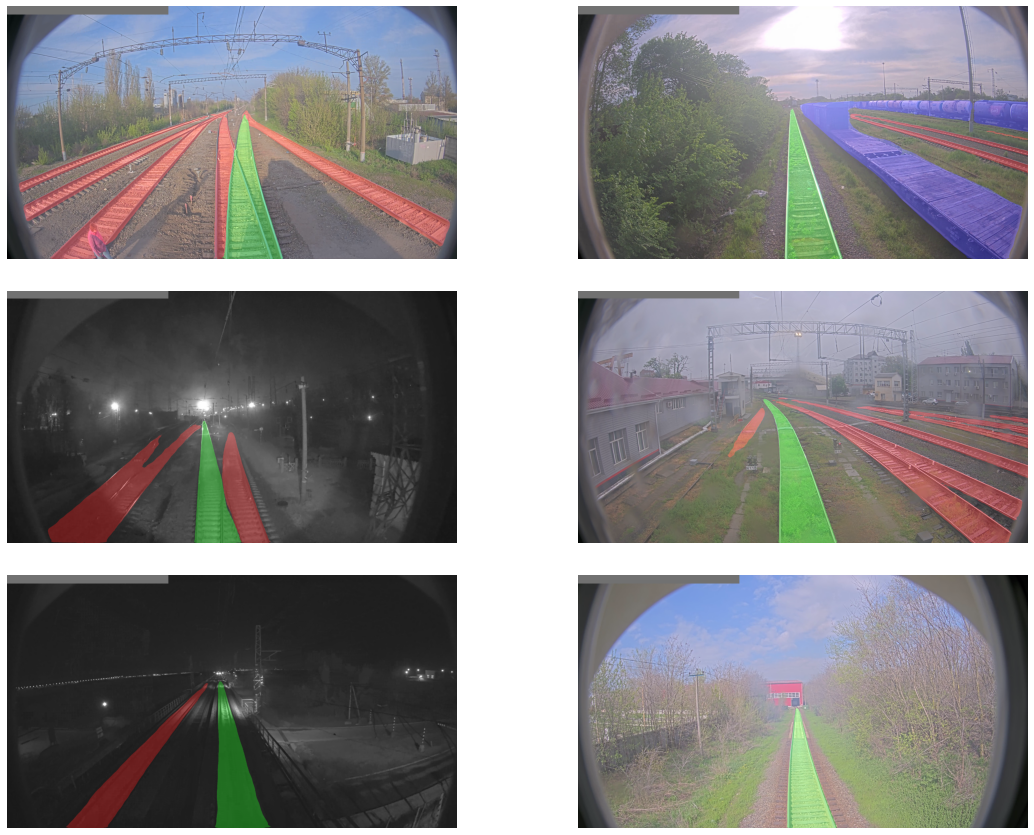

In [60]:
ids = np.random.choice(len(ALL_TEST_IMAGES) - 1, 6, replace=False)

images = []

for id in ids:
    image = cv2.imread(str(ALL_TEST_IMAGES[id]))
    image = image.astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image /= 255.

    mask = cv2.imread(f'{CWD}/submission/{ALL_TEST_IMAGES[id].name}')
    mask[:, :, 0] = mask[:, :, 0] == 6
    mask[:, :, 1] = mask[:, :, 1] == 7
    mask[:, :, 2] = mask[:, :, 2] == 10
    mask = mask.astype('float32')

    blend = np.clip(image + mask * .3, 0, 1)
    images.append(blend)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 12))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(images[2 * i + j])
        ax[i][j].set_axis_off()